In [ ]:
# Install packages
# Remember to Restart runtime after installation

# Change the versions to match the ones present in the docker image
!pip install itk==5.3rc4
!pip install vtk
!pip install itkwidgets
!pip install icon-registration==0.3.4
!pip install graphviz
!pip install tornado==6.1
!pip install coiled==0.0.76
!pip install dask==2022.03.0
!pip install distributed==2022.3.0
!pip install boto3
!pip install jupyter
!pip install pandas==1.4.3
!pip install numpy==1.21.5
!pip install lz4==4.0.0
!pip install git+https://github.com/uncbiag/mermaid.git
!pip install git+https://github.com/uncbiag/easyreg.git
!pip install git+https://github.com/uncbiag/OAI_analysis_2.git#egg=oai_package

In [1]:
# All Imports

import coiled
import dask
from dask import compute, visualize, delayed

import itk
import vtk
import itkwidgets
from oai_analysis_2 import dask_processing as dp
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'itkwidgets'

In [2]:
# Create Coiled Cluster with 2 workers

name = 'oai-processing21'

cluster = coiled.Cluster(
    n_workers=4,
    scheduler_cpu=4,
    scheduler_memory="16 GiB",
    worker_cpu=4,
    worker_memory="16 GiB",
    worker_gpu=1,
    name=name,
    worker_class="dask_cuda.CUDAWorker",
    software="gpu-test9",
)

client = dask.distributed.Client(cluster)

cluster

Output()

Found software environment build
Created fw rule: inbound [8786-8787] [0.0.0.0/0] []
Created FW rules: coiled-dask-pranjal09-154052-firewall
Created fw rule: cluster [0-65535] [None] [coiled-dask-pranjal09-154052-firewall -> coiled-dask-pranjal09-154052-firewall]
Created FW rules: coiled-dask-pranjal09-154052-cluster-firewall
Created fw rule: cluster [0-65535] [None] [coiled-dask-pranjal09-154052-cluster-firewall -> coiled-dask-pranjal09-154052-cluster-firewall]
Created scheduler VM: coiled-dask-pranjal09-154052-scheduler (type: t3.xlarge, ip: ['54.196.182.122'])


Mismatched versions found

+-------------+----------------+----------------+----------------+
| Package     | client         | scheduler      | workers        |
+-------------+----------------+----------------+----------------+
| cloudpickle | 2.0.0          | 2.1.0          | 2.1.0          |
| pandas      | 1.3.1          | 1.4.2          | 1.4.2          |
| python      | 3.8.12.final.0 | 3.9.13.final.0 | 3.9.13.final.0 |
+-------------+----------------+----------------+----------------+


In [75]:
# Main execution block

all_results = []
months_array = ['ENROLLMENT', '12_MONTH', '24_MONTH', '48_MONTH', '72_MONTH', '96_MONTH']
knee_type = 'LEFT_KNEE'
patient_id = '9010060'

for month in months_array:
    image_path = patient_id + '/MR_SAG_3D_DESS/' + knee_type + '/' + month + '/image_preprocessed.nii.gz'

    fc_probmap, tc_probmap = dp.segment_method(image_path)
    phi_AB, image_A, image_B = dp.register_images_delayed(
        image_path, 'atlas_image.nii.gz')

    deformed_fc = dp.deform_probmap_delayed(phi_AB, image_A, image_B,
                                            fc_probmap, 'FC')
    deformed_tc = dp.deform_probmap_delayed(phi_AB, image_A, image_B,
                                            tc_probmap, 'TC')

    thickness_fc = dp.get_thickness(deformed_fc, 'FC')
    thickness_tc = dp.get_thickness(deformed_tc, 'TC')

    result = [thickness_fc, thickness_tc]

    all_results.append(result)

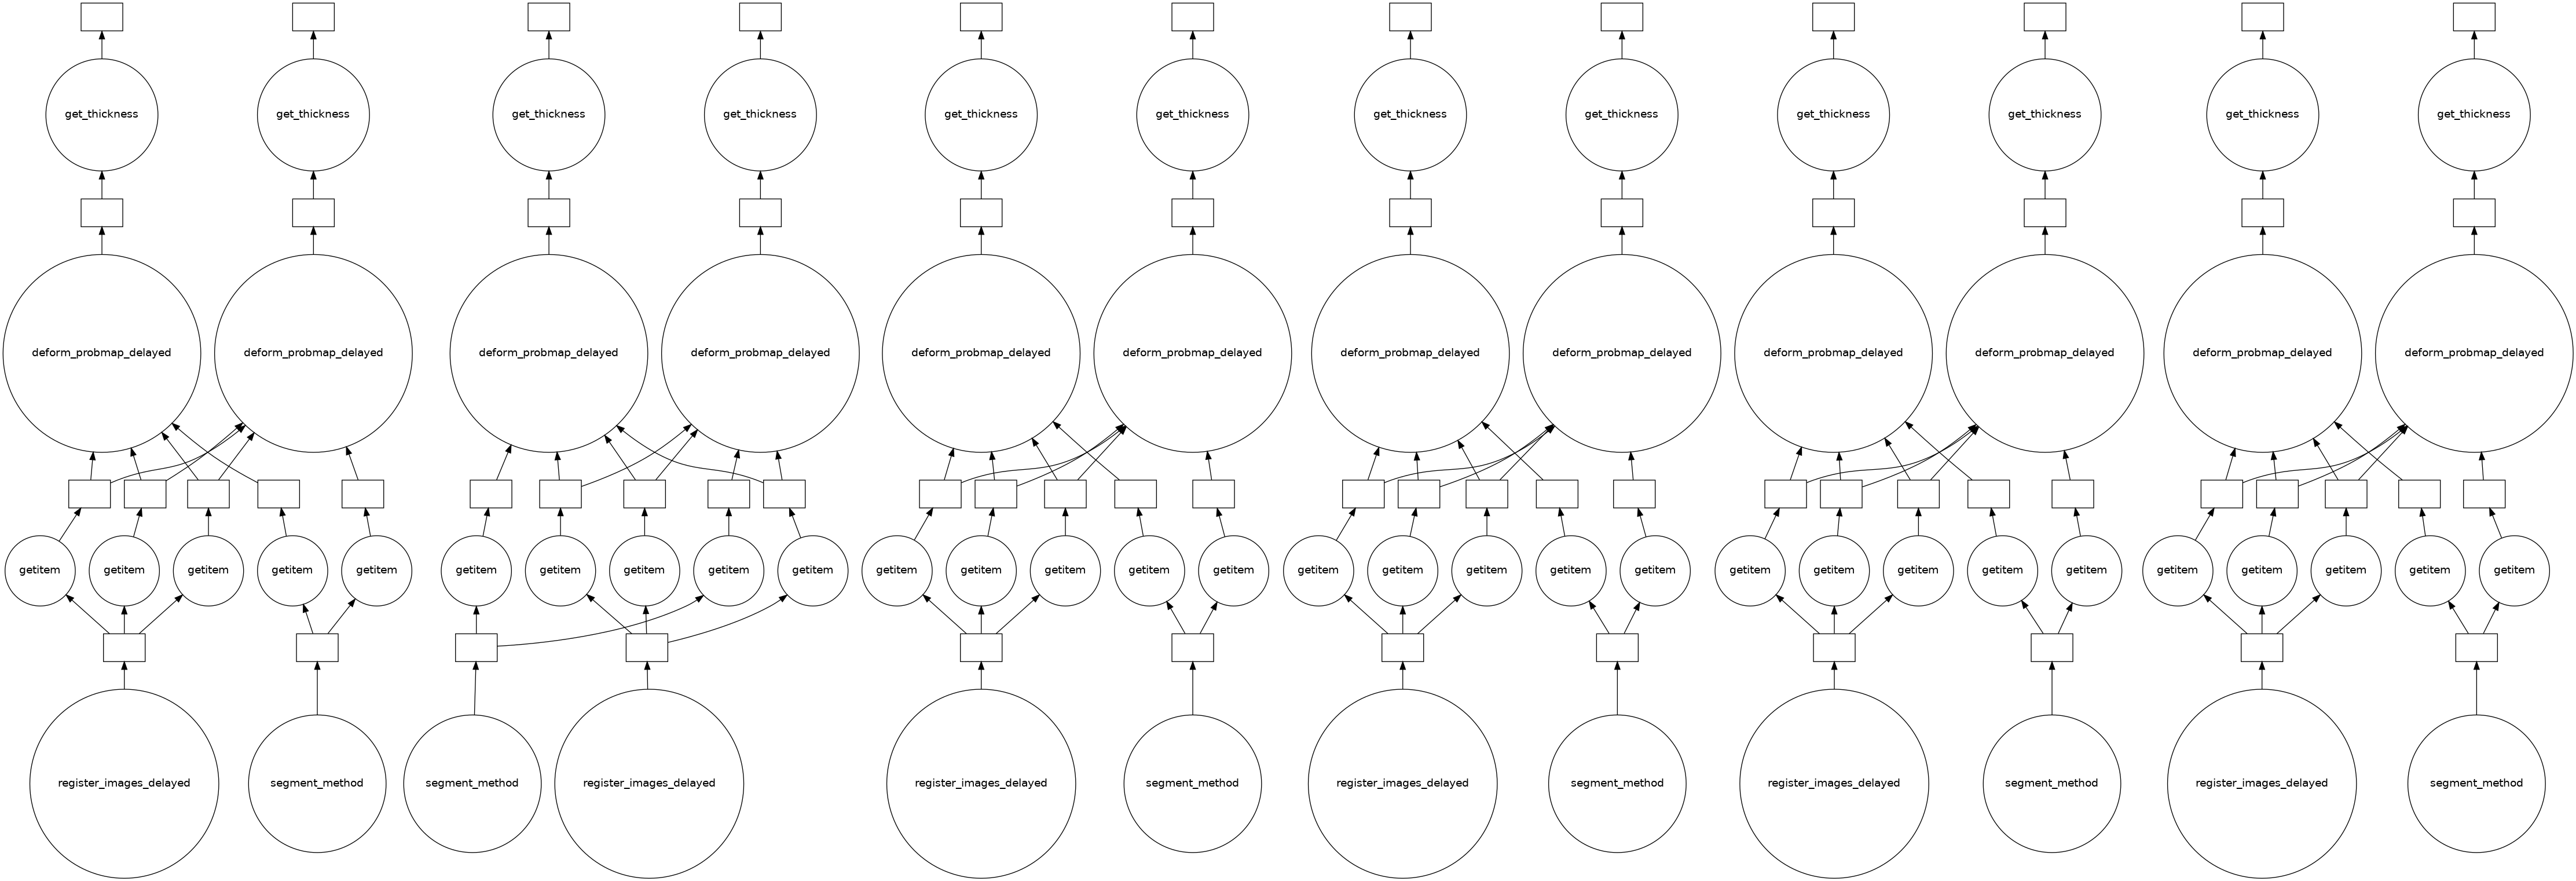

In [76]:
# Visualize Dask Computation Graph

visualize(*all_results)

In [77]:
%%time

output_result = compute(*all_results)

CPU times: user 228 ms, sys: 71.8 ms, total: 300 ms
Wall time: 1min 57s


In [78]:
# Write the meshes as vtk files

for i in range(len(output_result)):
    distance_inner_FC = itk.mesh_from_dict(output_result[i][0])
    distance_inner_TC = itk.mesh_from_dict(output_result[i][1])

    itk.meshwrite(distance_inner_FC, months_array[i]+'_itk_distance_inner_FC.vtk')
    itk.meshwrite(distance_inner_TC, months_array[i]+'_itk_distance_inner_TC.vtk')

In [79]:
# Read the meshes for viewing

month = months_array[5]

v1 = vtk.vtkPolyDataReader()
v1.SetFileName(month+'_itk_distance_inner_FC.vtk')
v1.Update()
m1 = v1.GetOutput()

v2 = vtk.vtkPolyDataReader()
v2.SetFileName(month+'_itk_distance_inner_TC.vtk')
v2.Update()
m2 = v2.GetOutput()

In [80]:
# Visualize the meshes

itkwidgets.view(geometries=[m1, m2])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [10]:
#cluster.close()

Cluster deleted successfully.

2022-06-04 15:12:21,105 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [21]:
# [STAR] Start Cluster

import coiled
import dask
from dask import compute, visualize, delayed

cluster = coiled.Cluster(
    name='gpucluster11',
    scheduler_vm_types=['t3.medium'],
    worker_vm_types=["g4dn.xlarge", "p3.2xlarge"],
    software="pranjal-sahu/gpu-test11",
    shutdown_on_close=True,
)

client = dask.distributed.Client(cluster)

Output()

Mismatched versions found

+-------------+-----------+-----------+---------+
| Package     | client    | scheduler | workers |
+-------------+-----------+-----------+---------+
| cloudpickle | 2.0.0     | 2.1.0     | None    |
| dask        | 2022.03.0 | 2022.6.0  | None    |
| distributed | 2022.3.0  | 2022.6.0  | None    |
+-------------+-----------+-----------+---------+


In [96]:
cluster.close()

In [61]:
# [TEST]

import dask
from dask import compute, visualize, delayed


def download_segmentation_weights():
    import os
    from os.path import exists
    if not exists("pretrained_OAI_model"):
        print("Downloading pretrained model (1.2 GB)")
        import urllib.request
        urllib.request.urlretrieve(
          "https://github.com/HastingsGreer/InverseConsistency/releases/download/pretrained_oai_model/knee_aligner_resi_net99900", "pretrained_OAI_model")

    trained_weights = torch.load("pretrained_OAI_model")
    fourth_net.load_state_dict(trained_weights)
    return

@delayed
def check_pytorch1():
    #import dask
    #return dask.__version__
    import os
    import torch
    import sys
    import platform
    #from sys import platform
    #return platform.platform()
    #return platform
    
    import numpy as np
    a = torch.Tensor(np.array([1, 7])).to(device='cuda')
    b = torch.Tensor(np.array([4, 1])).to(device='cuda')
    c = a + b
    return c.data.cpu()
    
    #os.system('pip install itk==5.3rc4.post2')
    #return 'Installation done'
    #os.environ["CONDA_DEFAULT_ENV"] = "coiled"
    #import subprocess
    #output = subprocess.check_output(['conda', 'info', '--envs'])
    #output = subprocess.check_output(['pip', 'install', '--upgrade',  'pip'])
    #output = subprocess.check_output(['ldd', '--version'])
    #output = subprocess.check_output(['pip', 'install', '--upgrade', 'pip'])
    output = subprocess.check_output(['pip', 'debug', '--verbose'])
    
    #return output
    #output = subprocess.check_output(['conda', 'activate', 'coiled'])
    #os.system('source activate coiled')    
    #return torch.__version__
    #return os.environ.items()
    #return os.environ['CONDA_DEFAULT_ENV']
    import torch
    return torch.__version__
    #import subprocess
    #output = subprocess.check_output(['conda', 'info', '--envs'])
    #return output
    #output = subprocess.check_output(['conda', 'list'])
    #import torch
    #return torch.cuda.is_available()
    #return output
    #print(output)
    #import os
    #return os.system('conda list')
    #import dask
    #return dask.__version__
    #import torch
    #return torch.cuda.is_available()

@delayed
def readimage():
    return "pranjal"




# out = check_pytorch1()
# output_result = compute(out)
# print(output_result)

In [94]:
# [STAR] For keeping cluster busy

import time

@delayed
def readimage():
    return "pranjal"

out = readimage()

for i in range(10000):
    time.sleep(5)
    output_result = compute(out)
    print(i, output_result)

0 ('pranjal',)
1 ('pranjal',)
2 ('pranjal',)


KeyboardInterrupt: 

In [163]:
from oai_analysis_2 import dask_processing as dp

In [92]:
image.SetMetaDataDictionary(itk.MetaDataDictionary())

In [100]:
xr_image  = xr.open_zarr('s3://oaisample1/ZARRDATA/atlas_image.zarr/scale0')
img = xr_image.get('image')

Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.


In [ ]:
image = itk.imread('/home/pranjal.sahu/Downloads/atlas_image.nii.gz')
image.SetMetaDataDictionary(itk.MetaDataDictionary())
image_da = itk.xarray_from_image(image)

#name = output_image_dir.stem
name = 'image'
image_ds = image_da.to_dataset(name='image')#, promote_attrs=True)

multiscale_image = msi.to_multiscale(image_ds.image, [2, 4], msi.Methods.ITK_GAUSSIAN)

output_image_dir = 's3://oaisample1/ZARRDATA/atlas_image.zarr'
store = s3fs.S3Map(root=output_image_dir, s3=s3, check=False)

chunk_size = 64
compressor = Blosc(cname='zstd', clevel=5, shuffle=Blosc.SHUFFLE)
multiscale_image.to_zarr(store, mode='w', compute=True,
            encoding={name: {'chunks': [chunk_size]*image.GetImageDimension(), 'compressor': compressor}})

In [19]:
cluster.close()

2022-08-04 01:25:33,205 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [22]:
atlas_path = "s3://oaisample1/ZARRDATA/atlas_image.zarr/scale0"

patient_id = '9000798'
months_array = [
    'Month-0', 'Month-12', 'Month-24', 'Month-36', 'Month-48', 'Month-72',
    'Month-96'
]

month = months_array[0]
image_path = "s3://oaisample1/ZARRDATA/PatientID-" + patient_id + '/' + month + '/Images/SAG_3D_DESS_0.zarr/scale0'


@delayed
def readimage(image_path):
    import xarray as xr
    import itk
    xr_dataset = xr.open_zarr(image_path)
    xr_array = xr_dataset.get('image')
    itk_image = itk.image_from_xarray(xr_array)
    itk_image = itk.cast_image_filter(itk_image,
                                      in_place=False,
                                      ttype=(type(itk_image), itk.Image[itk.F,
                                                                        3]))
    return itk_image

@delayed(nout=2)
def segment_method(image_A):
    import oai_analysis_2
    import torch
    import os
    from os.path import exists
    from oai_analysis_2 import utils
    from oai_analysis_2.segmentation import segmenter
    import boto3
    import itk
    import time

    if torch.cuda.is_available():
        device = "cuda"
    else:
        print("WARNING: CUDA NOT AVAILABLE, FALLING BACK TO CPU")
        device = "cpu"

    #if not exists("segmentation_model.pth.tar"):
    print("Downloading segmentation model")
    import urllib.request
    urllib.request.urlretrieve(
        "https://github.com/uncbiag/OAI_analysis_2/blob/master/data/segmentation_model.pth.tar?raw=true",
        "segmentation_model.pth.tar")
    urllib.request.urlretrieve(
        "https://github.com/uncbiag/OAI_analysis_2/blob/master/data/segmentation_train_config.pth.tar?raw=true",
        "segmentation_train_config.pth.tar")

    # Initialize segmenter
    segmenter_config = dict(
        ckpoint_path="segmentation_model.pth.tar",
        training_config_file="segmentation_train_config.pth.tar",
        device=device,
        batch_size=4,
        overlap_size=(16, 16, 8),
        output_prob=True,
        output_itk=True,
    )

    segmenter = oai_analysis_2.segmentation.segmenter.Segmenter3DInPatchClassWise(
        mode="pred", config=segmenter_config)

    # Segment downloaded image
    test_volume = image_A
    FC_probmap, TC_probmap = segmenter.segment(test_volume,
                                               if_output_prob_map=True,
                                               if_output_itk=True)

    return FC_probmap, TC_probmap

@delayed(nout=3)
def register_images_delayed(image_A_path, image_B_path):
    import itk
    import icon_registration
    import icon_registration.itk_wrapper as itk_wrapper
    import icon_registration.pretrained_models as pretrained_models
    from os.path import exists
    import torch
    import xarray as xr
    import time
    torch.set_num_threads(8)

    image_A_dataset = xr.open_zarr(image_A_path)
    image_B_dataset = xr.open_zarr(image_B_path)

    image_A_xarray = image_A_dataset.get('image')
    image_B_xarray = image_B_dataset.get('image')

    image_A = itk.image_from_xarray(image_A_xarray)
    image_B = itk.image_from_xarray(image_B_xarray)

    image_A = itk.cast_image_filter(image_A,
                                    in_place=False,
                                    ttype=(type(image_A), itk.Image[itk.D, 3]))
    image_B = itk.cast_image_filter(image_B,
                                    in_place=False,
                                    ttype=(type(image_B), itk.Image[itk.D, 3]))

    model = pretrained_models.OAI_knees_gradICON_model()
    if torch.cuda.is_available():
        model.cuda()
    else:
        model.to('cpu')

    # Register the images
    phi_AB, phi_BA = itk_wrapper.register_pair(model, image_A, image_B)
    return itk.dict_from_transform(phi_AB), image_A, image_B
    #return phi_AB, image_A, image_B

@delayed
def deform_probmap_delayed(phi_AB, image_A, image_B, prob, image_type='FC'):
    import itk

    phi_AB1 = itk.transform_from_dict(phi_AB)
    interpolator = itk.LinearInterpolateImageFunction.New(image_A)
    warped_image = itk.resample_image_filter(
        prob,
        transform=phi_AB1,
        interpolator=interpolator,
        size=itk.size(image_B),
        output_spacing=itk.spacing(image_B),
        output_direction=image_B.GetDirection(),
        output_origin=image_B.GetOrigin())
    
    return warped_image

@delayed(nout=1)
def get_thickness(warped_image, mesh_type):
    import itk
    import vtk
    import numpy as np
    import os
    from oai_analysis_2 import mesh_processing as mp

    def get_itk_mesh(vtk_mesh):
        Dimension = 3
        PixelType = itk.D
        
        # Get points array from VTK mesh
        points = vtk_mesh.GetPoints().GetData()
        points_numpy = np.array(points).flatten()#.astype('float32')
            
        polys = vtk_mesh.GetPolys().GetData()
        polys_numpy = np.array(polys).flatten()

        # Triangle Mesh
        vtk_cells_count = vtk_mesh.GetNumberOfPolys()
        polys_numpy = np.reshape(polys_numpy, [vtk_cells_count, Dimension+1])

        # Extracting only the points by removing first column that denotes the VTK cell type
        polys_numpy = polys_numpy[:, 1:]
        polys_numpy = polys_numpy.flatten().astype(np.uint64)

        # Get point data from VTK mesh to insert in ITK Mesh
        point_data_numpy = np.array(vtk_mesh.GetPointData().GetScalars())#.astype('float64')
        
        # Get cell data from VTK mesh to insert in ITK Mesh
        cell_data_numpy = np.array(vtk_mesh.GetCellData().GetScalars())#.astype('float64')
        
        MeshType = itk.Mesh[PixelType, Dimension]
        itk_mesh = MeshType.New()
        
        itk_mesh.SetPoints(itk.vector_container_from_array(points_numpy))
        itk_mesh.SetCellsArray(itk.vector_container_from_array(polys_numpy), itk.CommonEnums.CellGeometry_TRIANGLE_CELL)
        itk_mesh.SetPointData(itk.vector_container_from_array(point_data_numpy))
        itk_mesh.SetCellData(itk.vector_container_from_array(cell_data_numpy))    
        return itk_mesh
    
    distance_inner, distance_outer = mp.get_thickness_mesh(warped_image, mesh_type=mesh_type)
    distance_inner_itk = get_itk_mesh(distance_inner)
    distance_inner_itk_dict = itk.dict_from_mesh(distance_inner_itk)

    return distance_inner_itk

out = readimage(image_path)

fc_probmap, tc_probmap = segment_method(out)

phi_AB, image_A, image_B = register_images_delayed(image_path, atlas_path)

deformed_fc = deform_probmap_delayed(phi_AB, image_A, image_B,
                                            fc_probmap, 'FC')
deformed_tc = deform_probmap_delayed(phi_AB, image_A, image_B,
                                        tc_probmap, 'TC')
thickness_fc = get_thickness(deformed_fc, 'FC')
thickness_tc = get_thickness(deformed_tc, 'TC')
    
result = [thickness_fc, thickness_tc]

output_result = compute(result)
#print(output_result)

AttributeError: module 'skimage.measure' has no attribute 'marching_cubes_lewiner'

In [14]:
@delayed
def installitk():
    import subprocess
    output = subprocess.check_output(['pip', 'install', 'itkwidgets'])
    import itkwidgets
    #import os
    #os.system('pip install itkwidgets')
    #time.sleep(60)
    return

t = installitk()
compute(t)

(None,)

In [10]:
output_result[0][1]

<itk.itkImagePython.itkImageD3; proxy of <itk.itkImagePython.itkImageD3; proxy of <Swig Object of type 'itkImageD3 *' at 0x7f964ca2dc60> > >

In [ ]:
# Visualize Dask Computation Graph

visualize(*result)

In [111]:
cluster.close()

2022-08-04 00:57:02,766 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [164]:
# Main execution block

all_results = []
months_array = ['ENROLLMENT', '12_MONTH', '24_MONTH', '48_MONTH', '72_MONTH', '96_MONTH']
knee_type = 'LEFT_KNEE'
patient_id = '9010060'

for month in months_array:
    image_path = patient_id + '/MR_SAG_3D_DESS/' + knee_type + '/' + month + '/image_preprocessed.nii.gz'

    fc_probmap, tc_probmap = dp.segment_method(image_path)
    phi_AB, image_A, image_B = dp.register_images_delayed(
        image_path, 'atlas_image.nii.gz')

    deformed_fc = dp.deform_probmap_delayed(phi_AB, image_A, image_B,
                                            fc_probmap, 'FC')
    deformed_tc = dp.deform_probmap_delayed(phi_AB, image_A, image_B,
                                            tc_probmap, 'TC')

    thickness_fc = dp.get_thickness(deformed_fc, 'FC')
    thickness_tc = dp.get_thickness(deformed_tc, 'TC')

    result = [thickness_fc, thickness_tc]

    all_results.append(result)

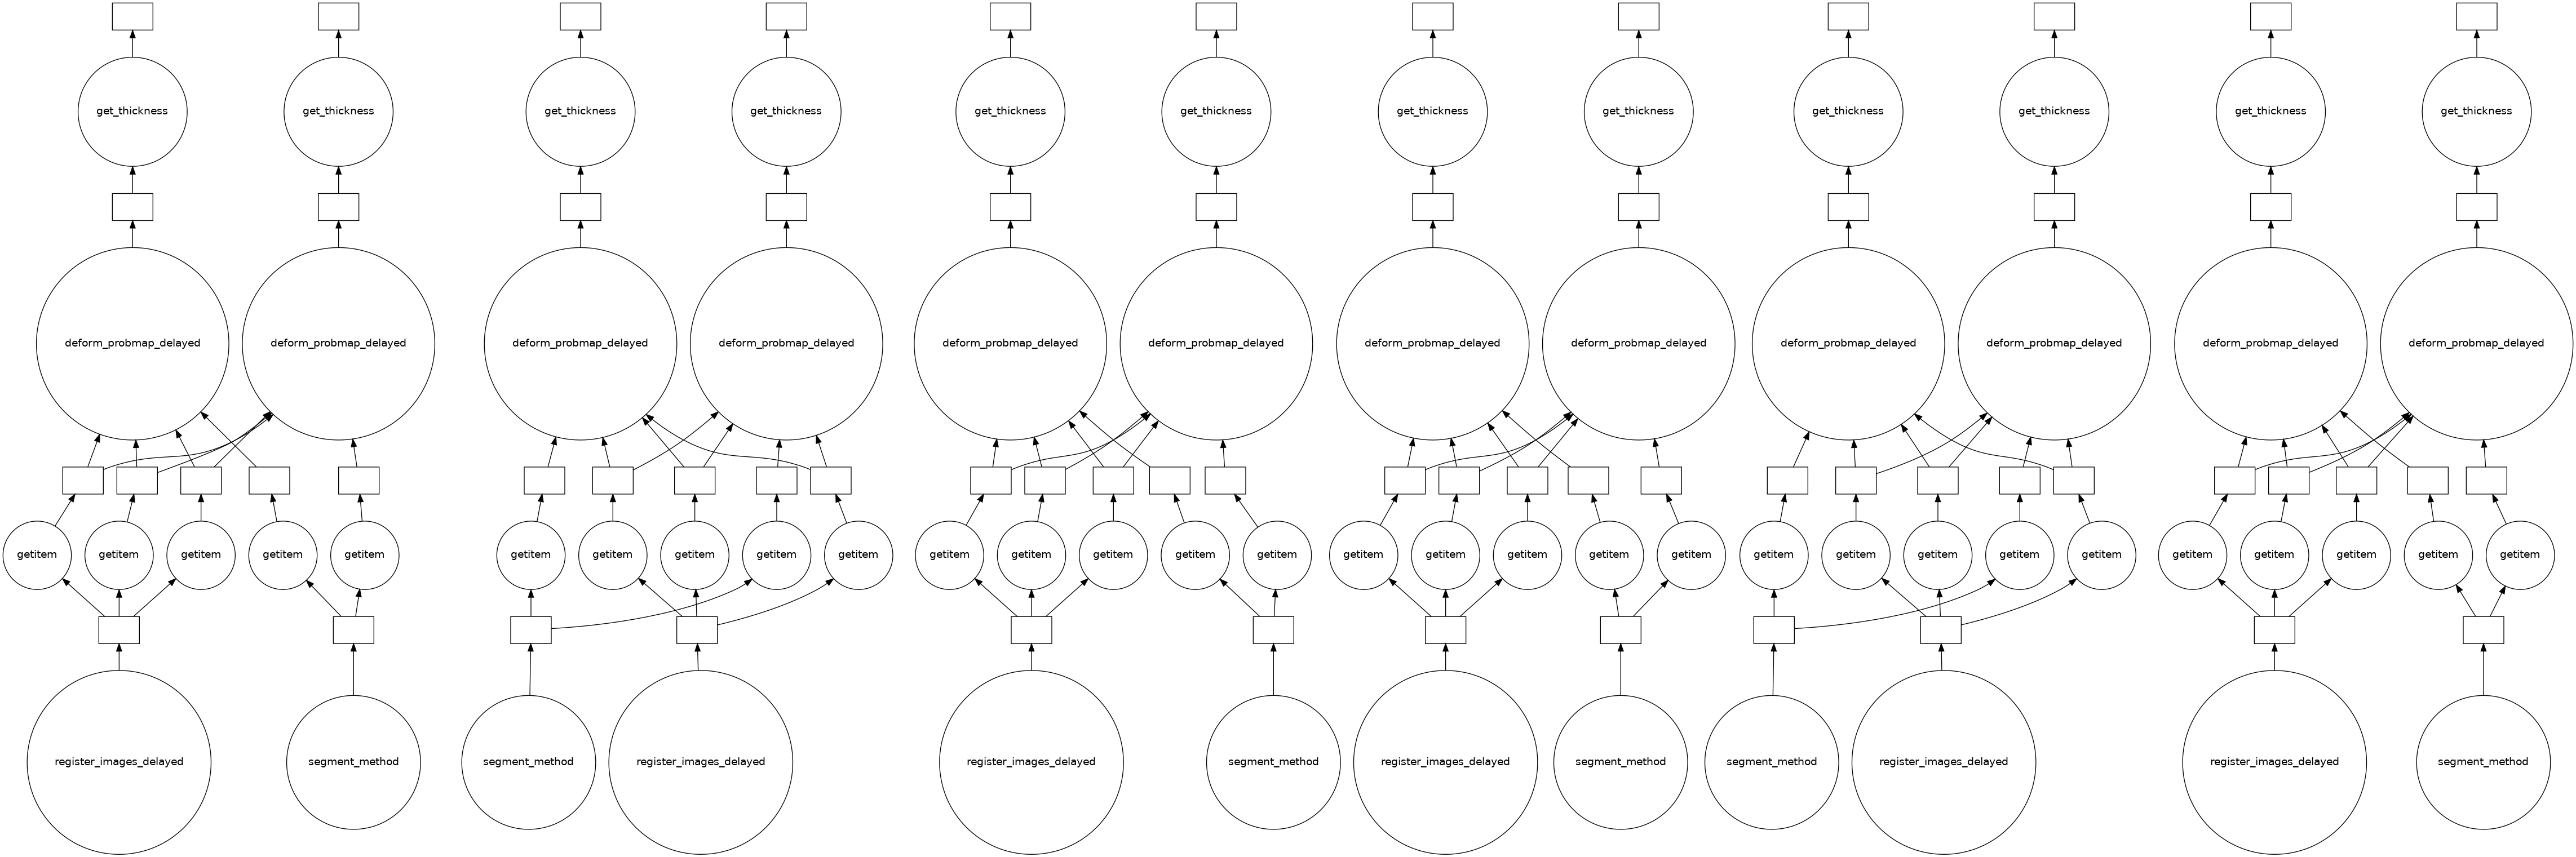

In [165]:
visualize(*all_results)

In [ ]:
#output_result[0].split('\n')
for k in str(output_result[0].decode("utf-8")).split('\n'):
    print(k)

In [167]:
@delayed(nout=3)
def register_images_delayed(image_A, image_B):
    import boto3
    import itk
    import icon_registration
    import icon_registration.itk_wrapper as itk_wrapper
    import icon_registration.pretrained_models as pretrained_models
    from os.path import exists
    import torch
    import time
    torch.set_num_threads(8)
    
    # Create temporary file names to download
#     image_A_filename = str(int(time.time()))+'_image_preprocessed.nii.gz'
#     image_B_filename = str(int(time.time()))+'_atlas_image.nii.gz'
    
#     s3          = boto3.resource("s3")
#     bucket_name = 'oaisample1'
#     bucket      = s3.Bucket(bucket_name)

#     s3.Bucket(bucket_name).download_file(image_A, image_A_filename)
#     s3.Bucket(bucket_name).download_file(image_B, image_B_filename)
    
#     image_A = itk.imread(image_A_filename, itk.D)
#     image_B = itk.imread(image_B_filename, itk.D)

    model = pretrained_models.OAI_knees_gradICON_model()
    if torch.cuda.is_available():
        model.cuda()
    else:
        model.to('cpu')

    # Register the images
    phi_AB, phi_BA = itk_wrapper.register_pair(model, image_A, image_B)
    return itk.dict_from_transform(phi_AB), itk.dict_from_image(image_A), itk.dict_from_image(image_B)

In [ ]:
import zarr
import xarray as xr
import numpy as np

filepath = 's3://oaisample1/ZARRDATA/PatientID-9000798/Month-0/Images/SAG_3D_DESS_0.zarr'

# Read a zarr file and check the laterality
z2 = zarr.open(filepath, mode='r')
print(z2)
image = z2['scale0/image']
image = np.array(image)
#print(image.shape)

p1 = xr.open_zarr(filepath)
#print(p1)
p1
#scale0 = z2['scale0']
#print(scale0.attrs['laterality'])

In [28]:
import xarray as xr

filepath = 's3://oaisample1/ZARRDATA/PatientID-9000798/Month-0/Images/SAG_3D_DESS_0.zarr/scale0'

p1 = xr.open_zarr(filepath)
#print(p1)
p1.dims

Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.


Frozen({'z': 160, 'y': 384, 'x': 384})

In [33]:
tuple(p1.dims).index('x')

2

In [35]:
p2 = tuple(['x', 'y'])
p3 = tuple(p2)
p3

('x', 'y')

In [30]:
img1 = itk.imread('/data/ITKPR22/ITK/ITK-build2/ExternalData/Testing/Data/Baseline/IO/cthead1.png', itk.F)
#print(img1.GetMetaDataDictionary())
img1_x = itk.xarray_from_image(img1)
img1_x.dims
#print(img1_x.dims.index('x'))

libpng warning: sCAL: invalid unit


('y', 'x')

libpng warning: sCAL: invalid unit
libpng warning: sCAL: invalid unit


In [16]:
import itk

img1 = itk.imread('/home/pranjal.sahu/Downloads/atlas_fc.nii.gz', itk.F)
#img1 = itk.imread('/data/ITKPR22/ITK/ITK-build2/ExternalData/Testing/Data/Baseline/IO/cthead1.png', itk.F)
#print(img1.shape)
#img1["MyMeta"]= 1.0

x_img = itk.xarray_from_image(img1)
#print(x_img)

#for k in img1.keys():
#    print('Checking key ', k)
#    print(img1[k])


#dict(img1)
#print(img1)
#print(dict(img1))
#print(img1.GetMetaDataDictionary())

RuntimeError: Can't downcast to a specialization of MetaDataObject

In [ ]:
dict()

In [36]:
o1 = img1.GetMetaDataDictionary()
o1.Get('qto_xyz')

RuntimeError: /work/ITK-source/ITK/Modules/Core/Common/src/itkMetaDataDictionary.cxx:77:
ITK ERROR: Key 'qto_xyz' does not exist 

In [14]:
help(itk.down_cast)

Help on function down_cast in module itk.support.extras:

down_cast(obj: 'itkt.LightObject')
    Down cast an itk.LightObject (or a object of a subclass) to its most
    specialized type.



In [ ]:
all_results = []
months_array = ['ENROLLMENT', '12_MONTH', '24_MONTH', '48_MONTH', '72_MONTH', '96_MONTH']
knee_type = 'LEFT_KNEE'
patient_id = '9010060'


# for month in months_array:
#     image_path = patient_id + '/MR_SAG_3D_DESS/' + knee_type + '/' + month + '/image_preprocessed.nii.gz'

#     fc_probmap, tc_probmap = dp.segment_method(image_path)
#phi_AB, image_A, image_B = dp.register_images_delayed(
#        image_path, 'atlas_image.nii.gz')
    
#register_images_delayed(image_A, image_B)

In [ ]:
output_result = compute(*all_results)

In [111]:
coiled.create_software_environment(
    name="gpu-test7_temp",
    container="pranjalsahu/pranjal-sahu-gpu-test7")

Creating new software environment
Creating container-only software environment
Successfully saved software environment build


In [156]:
cluster.close()

2022-07-29 17:08:31,540 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [ ]:
coiled.create_software_environment(
    name="gpu-test7",
    container="pytorch/pytorch:1.11.0-cuda11.3-cudnn8-runtime",
    conda_env_name="base",
    conda={
        "channels": [
            "rapidsai",
            "conda-forge",
            "defaults",
        ],
        "dependencies": [
            "dacoiled.create_software_environment(
    name="gpu-test9",
    container="pytorch/pytorch:1.11.0-cuda11.3-cudnn8-runtime",
    conda_env_name="base",
    conda={
        "channels": [
            "rapidsai",
            "conda-forge",
            "defaults",
        ],
        "dependencies": [
            "dask",
            "pytorch-gpu",
            "coiled-runtime"
        ],
    }
)sk",
            "pytorch-gpu",
            "python=3.10"
        ],
    }
)

In [157]:
coiled.create_software_environment(
    name="gpu-test9",
    container="pytorch/pytorch:1.11.0-cuda11.3-cudnn8-runtime",
    conda_env_name="base",
    conda={
        "channels": [
            "rapidsai",
            "conda-forge",
            "defaults",
        ],
        "dependencies": [
            "dask",
            "pytorch-gpu",
            "coiled-runtime"
        ],
    }
)

Creating new software environment
Creating new docker_hub build
STEP 1: FROM pytorch/pytorch:1.11.0-cuda11.3-cudnn8-runtime
STEP 2: COPY environment.yml environment.yml
--> Using cache d1d5917dfa8675c77beff84a30976fe7c01785025bc8c73297b3919e2f8d8413
--> d1d5917dfa8
STEP 3: RUN conda env update -n base -f environment.yml     && rm environment.yml     && conda clean --all -y     && echo "conda activate base" >> ~/.bashrc
Solving environment: ...working... done

packaging-21.3       | 36 KB     | ########## | 100% 
grpc-cpp-1.46.1      | 3.2 MB    | ########## | 100% 
xarray-2022.3.0      | 650 KB    | ########## | 100% 
aiobotocore-2.3.4    | 53 KB     | ########## | 100% 
libssh2-1.10.0       | 233 KB    | ########## | 100% 
libblas-3.9.0        | 13 KB     | ########## | 100% 
libev-4.33           | 104 KB    | ########## | 100% 
libtool-2.4.6        | 511 KB    | ########## | 100% 
cachetools-5.0.0     | 12 KB     | ########## | 100% 
openssl-1.1.1o       | 2.1 MB    | ########## | 10

pyrsistent-0.18.1    | 92 KB     | ########## | 100% 
typing-extensions-3. | 12 KB     | ########## | 100% 
cloudpickle-2.1.0    | 25 KB     | ########## | 100% 
librsvg-2.50.3       | 16.8 MB   | ########## | 100% 
zarr-2.11.3          | 115 KB    | ########## | 100% 
gflags-2.2.2         | 114 KB    | ########## | 100% 
libcrc32c-1.1.2      | 20 KB     | ########## | 100% 
numcodecs-0.9.1      | 1.0 MB    | ########## | 100% 
botocore-1.24.21     | 5.3 MB    | ########## | 100% 
glib-tools-2.68.4    | 86 KB     | ########## | 100% 
font-ttf-inconsolata | 94 KB     | ########## | 100% 
python-blosc-1.10.2  | 371 KB    | ########## | 100% 
nbconvert-6.4.5      | 6 KB      | ########## | 100% 
aws-sdk-cpp-1.8.185  | 1.9 MB    | ########## | 100% 
dask-labextension-5. | 38 KB     | ########## | 100% 
sleef-3.5.1          | 1.5 MB    | ########## | 100% 
libxcb-1.13          | 391 KB    | ########## | 100% 
libbrotlidec-1.0.9   | 33 KB     | ########## | 100% 
pyasn1-0.4.8         | 53 KB

pyasn1-0.4.8-py_0.tar.bz2                     53 KB
google-crc32c-1.1.2-py38h57c428a_3.tar.bz2      24 KB
c-ares-1.18.1-h7f98852_0.tar.bz2             113 KB
zipp-3.8.0-pyhd8ed1ab_0.tar.bz2               12 KB
libcblas-3.9.0-14_linux64_mkl.tar.bz2         12 KB
anyio-3.6.1-py38h578d9bd_0.tar.bz2           154 KB
protobuf-3.20.1-py38hfa26641_0.tar.bz2       332 KB
importlib_resources-5.9.0-pyhd8ed1ab_0.tar.bz2      28 KB
jupyterlab_pygments-0.2.2-pyhd8ed1ab_0.tar.bz2      17 KB
future-0.18.2-py38h578d9bd_5.tar.bz2         716 KB
krb5-1.19.3-h3790be6_0.tar.bz2               1.4 MB
libbrotlidec-1.0.9-h166bdaf_7.tar.bz2         33 KB
libiconv-1.16-h516909a_0.tar.bz2             1.4 MB
notebook-shim-0.1.0-pyhd8ed1ab_0.tar.bz2      15 KB
asciitree-0.3.3-py_2.tar.bz2                   6 KB
utf8proc-2.6.1-h27cfd23_0.conda              308 KB
gcsfs-2022.5.0-pyhd8ed1ab_0.tar.bz2           25 KB
pyarrow-8.0.0-py38h992f0b0_0.conda           2.6 MB
jupyter_core-4.11.1-py38h578d9bd_0.tar.bz2      81

coiled-runtime-0.0.4-hd8ed1ab_0               14 KB
nbconvert-6.4.5-pyhd8ed1ab_2                  18 KB
dask-2022.6.0-pyhd8ed1ab_0                    14 KB
python_abi-3.8-2_cp38                         11 KB
liblapack-3.9.0-14_linux64_mkl                45 KB
zstd-1.4.9-haebb681_0                        2.2 MB
typing-extensions-3.10.0.2-hd3eb1b0_0         37 KB
libcblas-3.9.0-14_linux64_mkl                 45 KB
fonts-conda-ecosystem-1-0                      9 KB
pytorch-gpu-1.11.0-cuda112py38h68407e5_1      27 KB
fonts-conda-forge-1-0                         11 KB
pthread-stubs-0.4-h36c2ea0_1001               14 KB
mkl-service-2.4.0-py38h7f8727e_0             204 KB


---------------------------------------------------
Total:                                      3.17 GB
removing certifi-2021.10.8-py38h06a4308_2
nbconvert-pandoc-6.4.5-pyhd8ed1ab_2           14 KB
removing libarchive-3.4.2-h62408e4_0
removing libgomp-9.3.0-h5101ec6_17
removing libiconv-1.15-h63c8f33_5
removing ca-certif

In [ ]:
coiled.create_software_environment(
    name="gpu-test10",
    container="pranjalsahu/oaiimageitk:v1",
    conda_env_name="base",
    pip="coiled_requirements.txt"
)